# Osteoporosis Detection using Machine Learning

In [1]:
import warnings
warnings.filterwarnings("ignore")

## Making of csv File

In [2]:
import os
import pandas as pd

data_path = "/kaggle/input/multi-class-knee-osteoporosis-x-ray-dataset/OS Collected Data"

images = []
labels = []

for subfolder in os.listdir(data_path):

    subfolder_path = os.path.join(data_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue

    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)

        labels.append(subfolder)

data = pd.DataFrame({'image': images, 'label': labels})

In [3]:
data.to_csv("/kaggle/working/Osteoporosis.csv")

In [4]:
df = pd.read_csv("/kaggle/working/Osteoporosis.csv")
df

,Unnamed: 0,image,label
0,0,/kaggle/input/multi-class-knee-osteoporosis-x-...,Osteopenia
1,1,/kaggle/input/multi-class-knee-osteoporosis-x-...,Osteopenia
2,2,/kaggle/input/multi-class-knee-osteoporosis-x-...,Osteopenia
3,3,/kaggle/input/multi-class-knee-osteoporosis-x-...,Osteopenia
4,4,/kaggle/input/multi-class-knee-osteoporosis-x-...,Osteopenia
...,...,...,...
1942,1942,/kaggle/input/multi-class-knee-osteoporosis-x-...,Normal
1943,1943,/kaggle/input/multi-class-knee-osteoporosis-x-...,Normal
1944,1944,/kaggle/input/multi-class-knee-osteoporosis-x-...,Normal
1945,1945,/kaggle/input/multi-class-knee-osteoporosis-x-...,Normal


In [5]:
df['label'].value_counts()

label
Osteoporosis    793
Normal          780
Osteopenia      374
Name: count, dtype: int64

## VGG 16

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 164s 6s/step - accuracy: 0.3666 - loss: 1.1576 - val_accuracy: 0.5599 - val_loss: 0.9733
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 112s 4s/step - accuracy: 0.4727 - loss: 1.0048 - val_accuracy: 0.5000 - val_loss: 0.9260
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 87s 4s/step - accuracy: 0.5369 - loss: 0.9297 - val_accuracy: 0.5767 - val_loss: 0.8801
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 87s 4s/step - accuracy: 0.6097 - loss: 0.8587 - val_accuracy: 0.6043 - val_loss: 0.8701
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 87s 4s/step - accuracy: 0.6301 - loss: 0.8375 - val_accuracy: 0.6104 - val_loss: 0.8428
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 96s 4s/step - accuracy: 0.6223 - loss: 0.8243 - val_accuracy: 0.6380 - val_loss: 0.8092
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 94s 4s/step - accuracy: 0.6442 - loss: 0.7977 - val_accuracy: 0.6779 - val_loss: 0.7882
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 94s 4s/step - accur

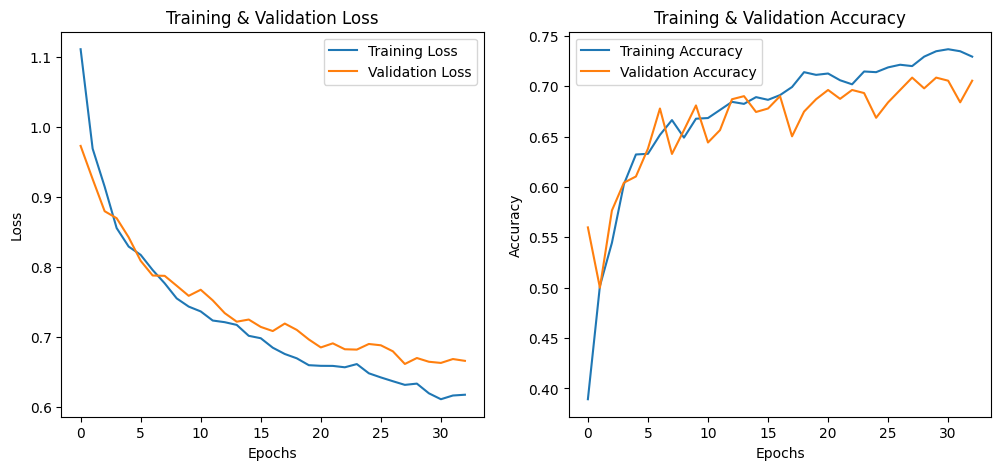

13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step


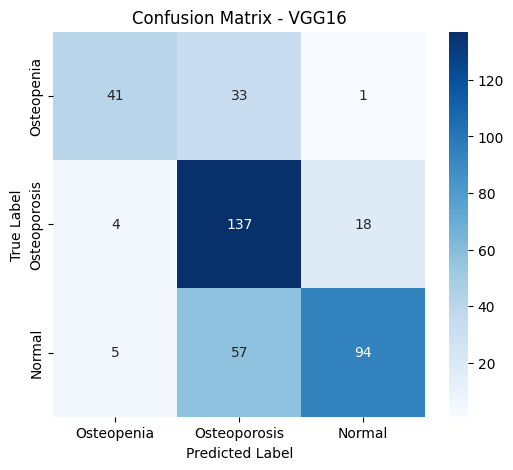

Classification Report:
              precision    recall  f1-score   support

  Osteopenia       0.82      0.55      0.66        75
Osteoporosis       0.60      0.86      0.71       159
      Normal       0.83      0.60      0.70       156

    accuracy                           0.70       390
   macro avg       0.75      0.67      0.69       390
weighted avg       0.74      0.70      0.70       390



In [6]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Load CSV file
csv_path = "/kaggle/working/Osteoporosis.csv"
df = pd.read_csv(csv_path)

# Encode labels
label_mapping = {label: idx for idx, label in enumerate(df['label'].unique())}
df['label'] = df['label'].map(label_mapping)

# Load and augment images using Pillow
def load_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path).convert('RGB').resize(target_size)
    img = img_to_array(img) / 255.0  # Normalize
    return img

image_paths = df['image'].values
labels = df['label'].values

# Split dataset (80% training, 20% validation)
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, stratify=labels)

# Data generator with augmentation
data_gen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.2, horizontal_flip=True)

def data_generator(image_paths, labels, batch_size=64):
    while True:
        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]
            images = np.array([load_image(img_path) for img_path in batch_paths])
            yield images, tf.keras.utils.to_categorical(batch_labels, num_classes=3)

train_gen = data_generator(train_paths, train_labels)
val_gen = data_generator(val_paths, val_labels)

# Define VGG16 Model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=len(train_paths) // 64,
    validation_steps=len(val_paths) // 64,
    epochs=100,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

# Save model
model.save("/kaggle/working/VGG16_knee_osteo_model.keras")
print("VGG16 training complete! Model saved.")

# Plot Training Loss and Accuracy
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training & Validation Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training & Validation Accuracy')
    
    plt.show()

plot_training_history(history)

# Confusion Matrix
val_images = np.array([load_image(img_path) for img_path in val_paths])
predictions = np.argmax(model.predict(val_images), axis=1)
cm = confusion_matrix(val_labels, predictions)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - VGG16')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(val_labels, predictions, target_names=label_mapping.keys()))


### VGG 16 Architecture

In [14]:
vgg16_model = tf.keras.models.load_model("/kaggle/working/VGG16_knee_osteo_model.keras")
print("\nLoaded VGG16 Model Architecture:")
vgg16_model.summary()


Loaded VGG16 Model Architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,6

 Total params: 14,912,843 (56.89 MB)

 Trainable params: 66,051 (258.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 132,104 (516.04 KB)

## VGG 19, InceptionV3, ResNet50

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Training VGG19 model...
Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 109s 5s/step - accuracy: 0.4134 - loss: 1.1467 - val_accuracy: 0.4792 - val_loss: 0.9681
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 91s 4s/step - accuracy: 0.4948 - loss: 0.9953 - val_accuracy: 0.6043 - val_loss: 0.9321
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.5321 - loss: 0.9557 - val_accuracy: 0.6442 - val_loss: 0.8709
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - accuracy: 0.5684 - loss: 0.9161 - val_accuracy: 0.6534 - val_loss: 0.8703
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 86s 4s/step - accuracy: 0.6061 - loss: 0.8740 - val_accuracy: 0.6779 - val_loss: 0.8421
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 86s 4s/step - accuracy: 0.6207 - loss: 0.8518 - val_accuracy: 0.6902 - val_loss: 0.8220
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accurac

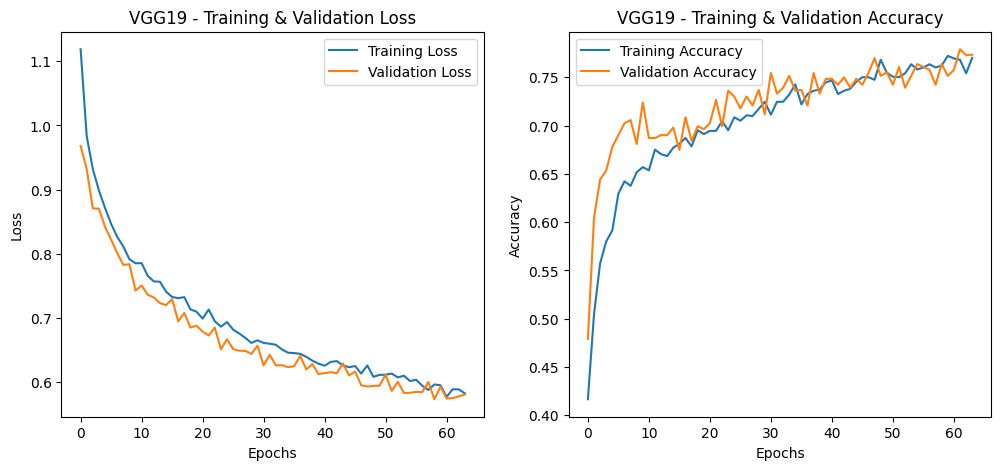

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step


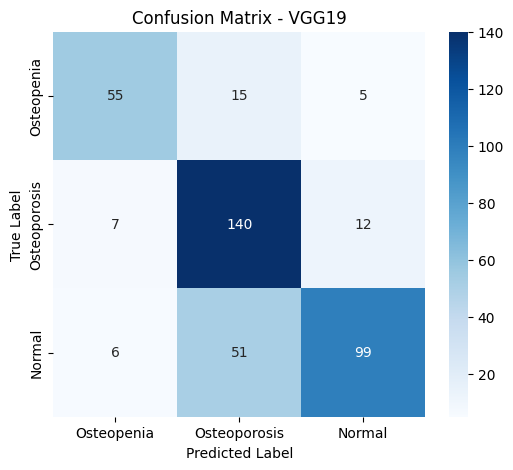

Classification Report for VGG19:
              precision    recall  f1-score   support

  Osteopenia       0.81      0.73      0.77        75
Osteoporosis       0.68      0.88      0.77       159
      Normal       0.85      0.63      0.73       156

    accuracy                           0.75       390
   macro avg       0.78      0.75      0.75       390
weighted avg       0.77      0.75      0.75       390

Training InceptionV3 model...
Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 125s 5s/step - accuracy: 0.4674 - loss: 1.3867 - val_accuracy: 0.6840 - val_loss: 0.7152
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 94s 4s/step - accuracy: 0.6701 - loss: 0.7234 - val_accuracy: 0.7086 - val_loss: 0.6440
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 90s 4s/step - accuracy: 0.7152 - loss: 0.6715 - val_accuracy: 0.7083 - val_loss: 0.6248
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 0.7039 - loss: 0.6616 - val_accuracy: 0.7055 - val_loss: 0.6153
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 89s 4s/s

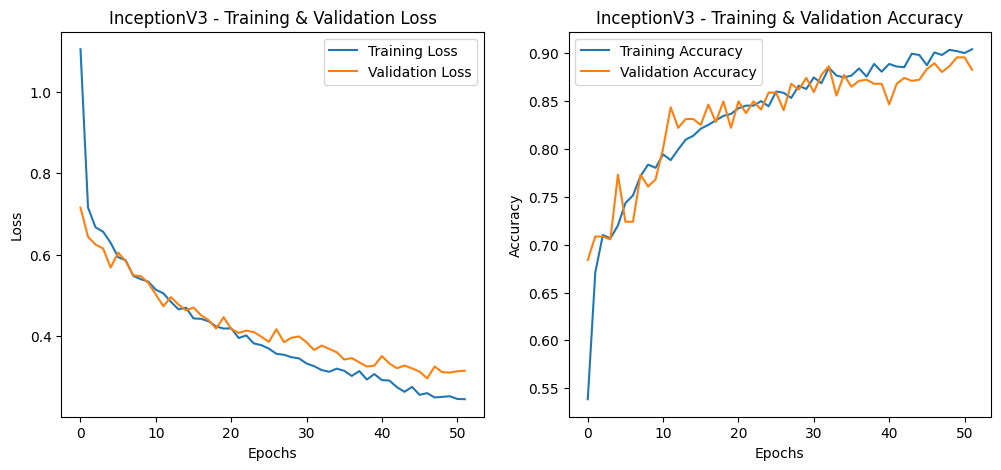

13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 396ms/step


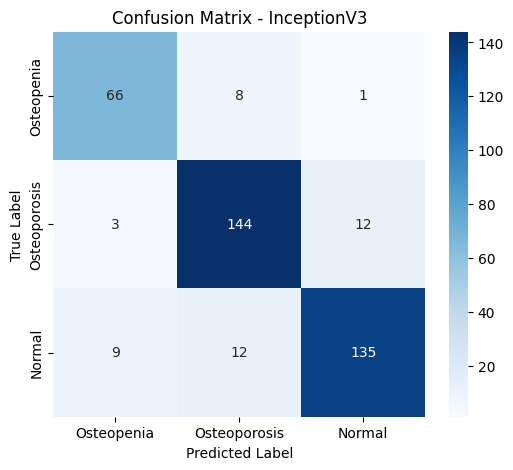

Classification Report for InceptionV3:
              precision    recall  f1-score   support

  Osteopenia       0.85      0.88      0.86        75
Osteoporosis       0.88      0.91      0.89       159
      Normal       0.91      0.87      0.89       156

    accuracy                           0.88       390
   macro avg       0.88      0.88      0.88       390
weighted avg       0.89      0.88      0.88       390

Training ResNet50 model...
Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 119s 5s/step - accuracy: 0.3621 - loss: 1.2994 - val_accuracy: 0.4877 - val_loss: 1.0318
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.4239 - loss: 1.0503 - val_accuracy: 0.5613 - val_loss: 1.0160
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - accuracy: 0.4428 - loss: 1.0359 - val_accuracy: 0.5365 - val_loss: 0.9984
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.4843 - loss: 1.0206 - val_accuracy: 0.3926 - val_loss: 1.0067
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 81s 3

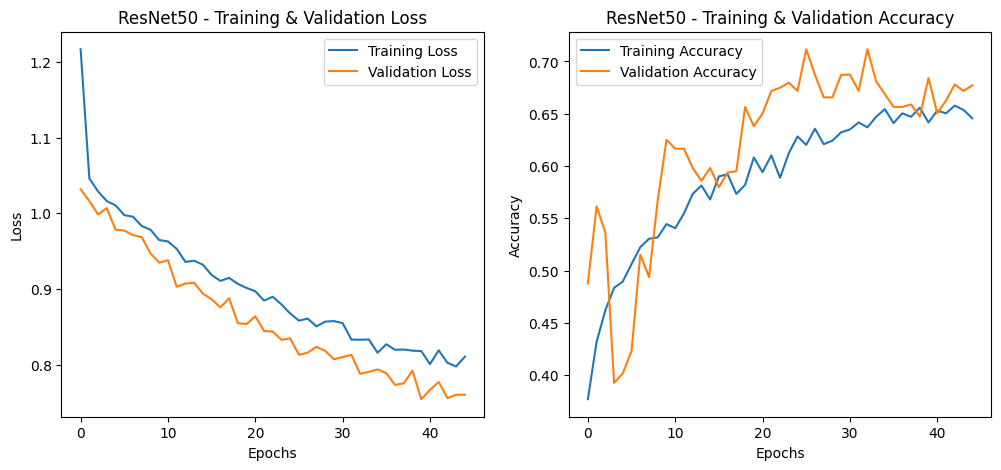

13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 307ms/step


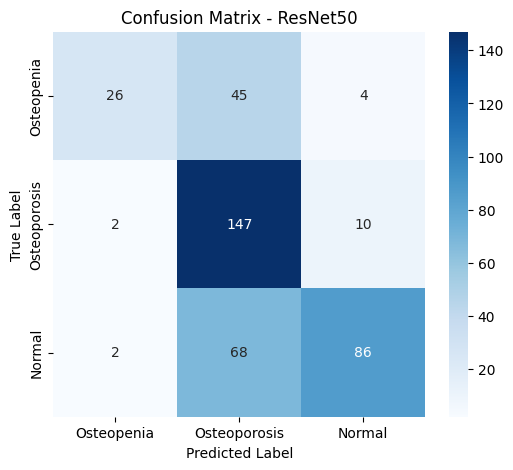

Classification Report for ResNet50:
              precision    recall  f1-score   support

  Osteopenia       0.87      0.35      0.50        75
Osteoporosis       0.57      0.92      0.70       159
      Normal       0.86      0.55      0.67       156

    accuracy                           0.66       390
   macro avg       0.76      0.61      0.62       390
weighted avg       0.74      0.66      0.65       390



In [7]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19, InceptionV3, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Load CSV file
csv_path = "/kaggle/working/Osteoporosis.csv"
df = pd.read_csv(csv_path)

# Encode labels
label_mapping = {label: idx for idx, label in enumerate(df['label'].unique())}
df['label'] = df['label'].map(label_mapping)

# Load and augment images using Pillow
def load_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path).convert('RGB').resize(target_size)
    img = img_to_array(img) / 255.0  # Normalize
    return img

image_paths = df['image'].values
labels = df['label'].values

# Split dataset (80% training, 20% validation)
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, stratify=labels)

# Data generator with augmentation
data_gen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.2, horizontal_flip=True)

def data_generator(image_paths, labels, batch_size=64):
    while True:
        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]
            images = np.array([load_image(img_path) for img_path in batch_paths])
            yield images, tf.keras.utils.to_categorical(batch_labels, num_classes=3)

train_gen = data_generator(train_paths, train_labels)
val_gen = data_generator(val_paths, val_labels)

# Function to create model
def create_model(base_model):
    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(3, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

models = {
    "VGG19": VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    "InceptionV3": InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    "ResNet50": ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
}

for model_name, base_model in models.items():
    print(f"Training {model_name} model...")
    model = create_model(base_model)
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        steps_per_epoch=len(train_paths) // 64,
        validation_steps=len(val_paths) // 64,
        epochs=100,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
    )
    model.save(f"/kaggle/working/{model_name}_knee_osteo_model.keras")
    print(f"{model_name} training complete! Model saved.")
    
    # Plot Training Loss and Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'{model_name} - Training & Validation Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'{model_name} - Training & Validation Accuracy')
    
    plt.show()
    
    # Confusion Matrix
    val_images = np.array([load_image(img_path) for img_path in val_paths])
    predictions = np.argmax(model.predict(val_images), axis=1)
    cm = confusion_matrix(val_labels, predictions)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()
    
    # Classification Report
    print(f"Classification Report for {model_name}:")
    print(classification_report(val_labels, predictions, target_names=label_mapping.keys()))

### VGG 19 Architecture 

In [15]:
vgg19_model = tf.keras.models.load_model("/kaggle/working/VGG19_knee_osteo_model.keras")
print("\nLoaded VGG19 Model Architecture:")
vgg19_model.summary()


Loaded VGG19 Model Architecture:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,222,539 (77.14 MB)

 Trainable params: 66,051 (258.01 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

 Optimizer params: 132,104 (516.04 KB)

### InceptionV3 Architecture 

In [16]:
inception_model = tf.keras.models.load_model("/kaggle/working/InceptionV3_knee_osteo_model.keras")
print("\nLoaded InceptionV3 Model Architecture:")
inception_model.summary()


Loaded InceptionV3 Model Architecture:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 111, 111, 32)   │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 111, 111, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 109, 109, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 109, 109, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 109, 109, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 109, 109, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 109, 109, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 109, 109, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 54, 54, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 54, 54, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 54, 54, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 52, 52, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 52, 52, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 22,590,763 (86.18 MB)

 Trainable params: 262,659 (1.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

 Optimizer params: 525,320 (2.00 MB)

### ResNet 50 Architecture 

In [17]:
resnet_model = tf.keras.models.load_model("/kaggle/working/ResNet50_knee_osteo_model.keras")
print("\nLoaded ResNet50 Model Architecture:")
resnet_model.summary()


Loaded ResNet50 Model Architecture:


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,375,691 (92.99 MB)

 Trainable params: 262,659 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 525,320 (2.00 MB)

## Xception, AlexNet

Training Xception model...
Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 138s 5s/step - accuracy: 0.5498 - loss: 0.9305 - val_accuracy: 0.7292 - val_loss: 0.6609
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 100s 4s/step - accuracy: 0.6933 - loss: 0.6714 - val_accuracy: 0.7577 - val_loss: 0.6135
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.7192 - loss: 0.6411 - val_accuracy: 0.7638 - val_loss: 0.6129
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.7566 - loss: 0.5912 - val_accuracy: 0.7454 - val_loss: 0.5948
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 85s 4s/step - accuracy: 0.7604 - loss: 0.5712 - val_accuracy: 0.7423 - val_loss: 0.5736
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 86s 4s/step - accuracy: 0.7761 - loss: 0.5349 - val_accuracy: 0.7638 - val_loss: 0.5565
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.7747 - loss: 0.5410 - val_accuracy: 0.7546 - val_loss: 0.5843
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.8128 - loss: 0.49

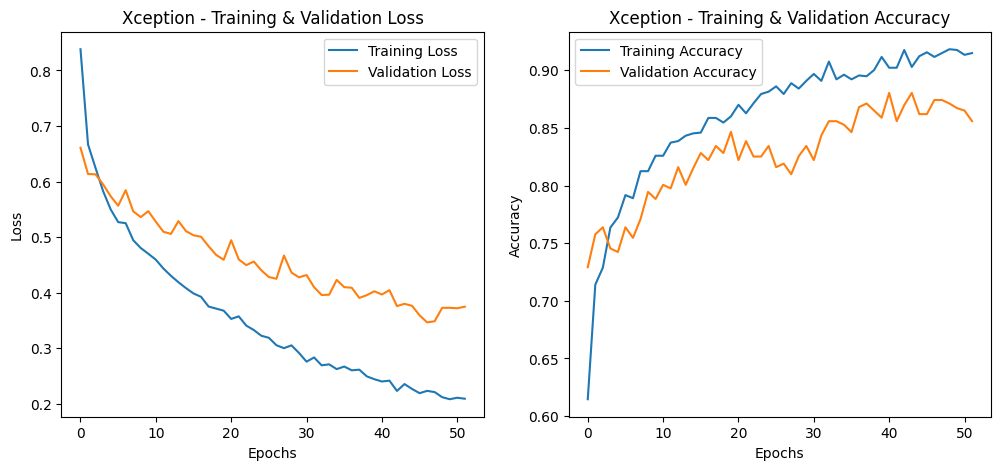

13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 289ms/step


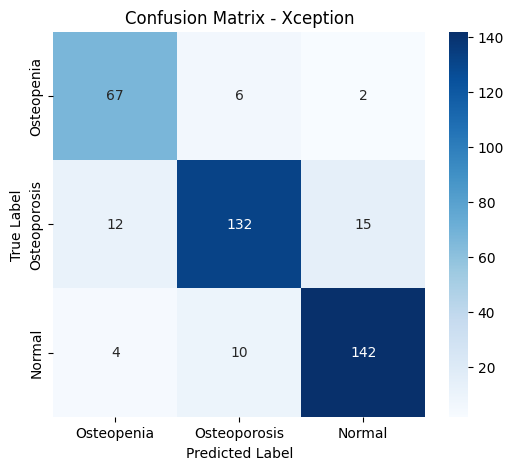

Classification Report for Xception:
              precision    recall  f1-score   support

  Osteopenia       0.81      0.89      0.85        75
Osteoporosis       0.89      0.83      0.86       159
      Normal       0.89      0.91      0.90       156

    accuracy                           0.87       390
   macro avg       0.86      0.88      0.87       390
weighted avg       0.88      0.87      0.87       390

Training AlexNet model...
Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 112s 5s/step - accuracy: 0.4369 - loss: 1.0138 - val_accuracy: 0.5798 - val_loss: 0.8441
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 100s 4s/step - accuracy: 0.5704 - loss: 0.8407 - val_accuracy: 0.6094 - val_loss: 0.7808
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 87s 4s/step - accuracy: 0.5736 - loss: 0.8180 - val_accuracy: 0.6288 - val_loss: 0.7701
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 86s 4s/step - accuracy: 0.5619 - loss: 0.8121 - val_accuracy: 0.6166 - val_loss: 0.7523
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 92s 4s/s

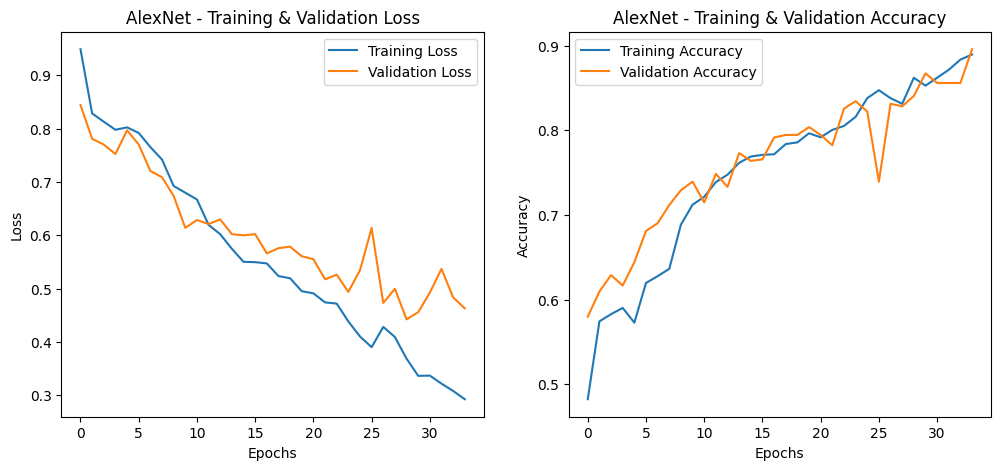

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


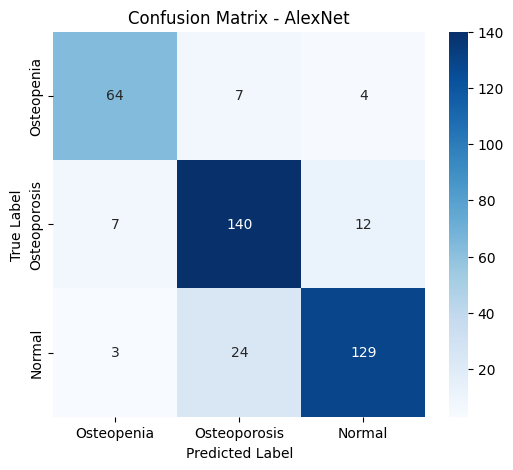

Classification Report for AlexNet:
              precision    recall  f1-score   support

  Osteopenia       0.86      0.85      0.86        75
Osteoporosis       0.82      0.88      0.85       159
      Normal       0.89      0.83      0.86       156

    accuracy                           0.85       390
   macro avg       0.86      0.85      0.85       390
weighted avg       0.86      0.85      0.85       390



In [9]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Input

# Load CSV file
csv_path = "/kaggle/working/Osteoporosis.csv"
df = pd.read_csv(csv_path)

# Encode labels
label_mapping = {label: idx for idx, label in enumerate(df['label'].unique())}
df['label'] = df['label'].map(label_mapping)

# Load and augment images using Pillow
def load_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path).convert('RGB').resize(target_size)
    img = img_to_array(img) / 255.0  # Normalize
    return img

image_paths = df['image'].values
labels = df['label'].values

# Split dataset (80% training, 20% validation)
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, stratify=labels)

# Data generator with augmentation
data_gen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.2, horizontal_flip=True)

def data_generator(image_paths, labels, batch_size=64):
    while True:
        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]
            images = np.array([load_image(img_path) for img_path in batch_paths])
            yield images, tf.keras.utils.to_categorical(batch_labels, num_classes=3)

train_gen = data_generator(train_paths, train_labels)
val_gen = data_generator(val_paths, val_labels)

# Function to create Xception model
def create_xception_model():
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(3, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Function to create AlexNet model
def create_alexnet_model():
    model = Sequential([
        Input(shape=(224, 224, 3)),
        Conv2D(64, (11, 11), strides=4, activation='relu'),
        MaxPooling2D((3, 3), strides=2),
        Conv2D(64, (5, 5), activation='relu'),
        MaxPooling2D((3, 3), strides=2),
        Conv2D(384, (3, 3), activation='relu'),
        Conv2D(384, (3, 3), activation='relu'),
        Conv2D(384, (3, 3), activation='relu'),
        MaxPooling2D((3, 3), strides=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

models = {
    "Xception": create_xception_model(),
    "AlexNet": create_alexnet_model()
}

for model_name, model in models.items():
    print(f"Training {model_name} model...")
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        steps_per_epoch=len(train_paths) // 64,
        validation_steps=len(val_paths) // 64,
        epochs=100,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
    )
    model.save(f"/kaggle/working/{model_name}_knee_osteo_model.keras")
    print(f"{model_name} training complete! Model saved.")
    
    # Plot Training Loss and Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'{model_name} - Training & Validation Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'{model_name} - Training & Validation Accuracy')
    
    plt.show()
    
    # Confusion Matrix
    val_images = np.array([load_image(img_path) for img_path in val_paths])
    predictions = np.argmax(model.predict(val_images), axis=1)
    cm = confusion_matrix(val_labels, predictions)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()
    
    # Classification Report
    print(f"Classification Report for {model_name}:")
    print(classification_report(val_labels, predictions, target_names=label_mapping.keys()))


### Xception Architecture 

In [18]:
xception_model = tf.keras.models.load_model("/kaggle/working/Xception_knee_osteo_model.keras")
print("\nLoaded Xception Model Architecture:")
xception_model.summary()


Loaded Xception Model Architecture:


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 111, 111, 32)   │            864 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 111, 111, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 111, 111, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 109, 109, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 109, 109, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 109, 109, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 109, 109, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 109, 109, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 109, 109, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_98 (Conv2D)        │ (None, 55, 55, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 55, 55, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 21,649,459 (82.59 MB)

 Trainable params: 262,659 (1.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

 Optimizer params: 525,320 (2.00 MB)

### AlexNet Architecture

In [19]:
alexnet_model = tf.keras.models.load_model("/kaggle/working/AlexNet_knee_osteo_model.keras")
print("\nLoaded AlexNet Model Architecture:")
alexnet_model.summary()


Loaded AlexNet Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_102 (Conv2D)                  │ (None, 54, 54, 64)          │          23,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_103 (Conv2D)                  │ (None, 22, 22, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_104 (Conv2D)                  │ (None, 8, 8, 384)           │         221,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_105 (Conv2D)                  │ (None, 6, 6, 384)           │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_106 (Conv2D)                  │ (None, 4, 4, 384)           │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 1, 1, 384)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,155,915 (34.93 MB)

 Trainable params: 3,051,971 (11.64 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,103,944 (23.28 MB)

## Custom CNN 1 Model

Training Custom CNN model...
Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 332s 6s/step - accuracy: 0.3899 - loss: 13.7959 - val_accuracy: 0.3984 - val_loss: 147.3615
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 177s 5s/step - accuracy: 0.4426 - loss: 6.0018 - val_accuracy: 0.4325 - val_loss: 9.6365
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 100s 4s/step - accuracy: 0.5291 - loss: 4.3207 - val_accuracy: 0.4356 - val_loss: 3.5375
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 96s 4s/step - accuracy: 0.4696 - loss: 3.7679 - val_accuracy: 0.4387 - val_loss: 3.6125
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 97s 4s/step - accuracy: 0.5374 - loss: 3.3371 - val_accuracy: 0.5368 - val_loss: 3.0876
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.5528 - loss: 3.0947 - val_accuracy: 0.6503 - val_loss: 2.9174
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 96s 4s/step - accuracy: 0.5863 - loss: 2.9018 - val_accuracy: 0.4908 - val_loss: 2.8325
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 99s 4s/step - accuracy: 0.6075 - loss

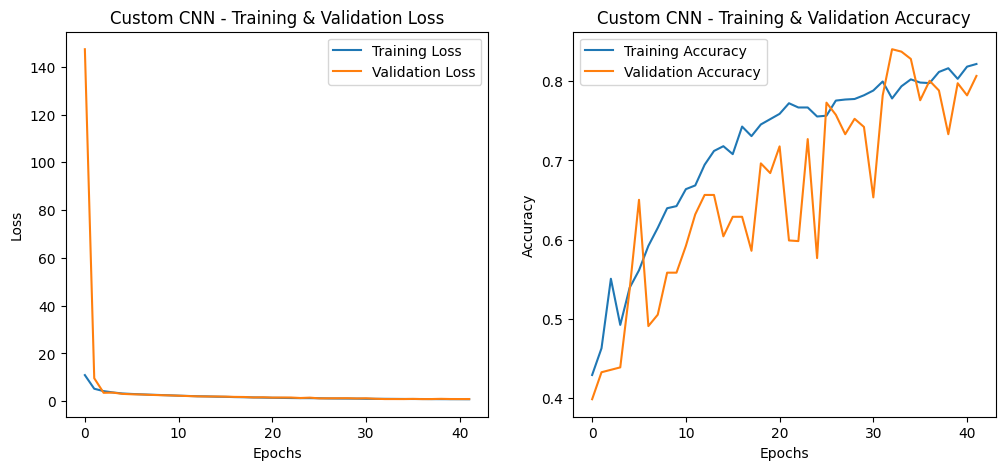

13/13 ━━━━━━━━━━━━━━━━━━━━ 39s 742ms/step


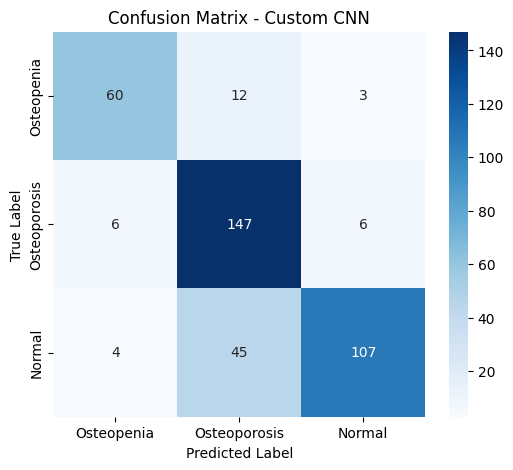

Classification Report for Custom CNN:
              precision    recall  f1-score   support

  Osteopenia       0.86      0.80      0.83        75
Osteoporosis       0.72      0.92      0.81       159
      Normal       0.92      0.69      0.79       156

    accuracy                           0.81       390
   macro avg       0.83      0.80      0.81       390
weighted avg       0.83      0.81      0.80       390



In [ ]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.regularizers import l2

# Load CSV file
csv_path = "/kaggle/working/Osteoporosis.csv"
df = pd.read_csv(csv_path)

# Encode labels
label_mapping = {label: idx for idx, label in enumerate(df['label'].unique())}
df['label'] = df['label'].map(label_mapping)

# Load and augment images using Pillow
def load_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path).convert('RGB').resize(target_size)
    img = img_to_array(img) / 255.0  # Normalize
    return img

image_paths = df['image'].values
labels = df['label'].values

# Split dataset (80% training, 20% validation)
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, stratify=labels)

# Data generator with augmentation
data_gen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.2, horizontal_flip=True)

def data_generator(image_paths, labels, batch_size=64):
    while True:
        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]
            images = np.array([load_image(img_path) for img_path in batch_paths])
            yield images, tf.keras.utils.to_categorical(batch_labels, num_classes=3)

train_gen = data_generator(train_paths, train_labels)
val_gen = data_generator(val_paths, val_labels)

# Function to create Custom CNN model
def create_custom_cnn():
    model = Sequential()
    
    # Input Layer
    model.add(Conv2D(128, (8, 8), activation=None, kernel_regularizer=l2(0.001), input_shape=(224, 224, 3)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    
    # First Conv Block
    model.add(Conv2D(256, (5, 5), activation=None, kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D((3, 3)))
    
    # Second Conv Block
    model.add(Conv2D(256, (3, 3), activation=None, kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    
    # Bottleneck using 1x1 Convolutions
    model.add(Conv2D(256, (1, 1), activation=None, kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    
    # Third Conv Block
    model.add(Conv2D(512, (3, 3), activation=None, kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D((2, 2)))
    
    # Fourth Conv Block
    model.add(Conv2D(512, (3, 3), activation=None, kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D((2, 2)))
    
    # Extra Layer - Enhancing Feature Extraction
    model.add(Conv2D(1024, (3, 3), activation=None, kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D((2, 2)))
    
    # Flatten and Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))  # 3 classes
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Train and Evaluate the Custom CNN Model
model = create_custom_cnn()
print("Training Custom CNN model...")
history = model.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=len(train_paths) // 64,
    validation_steps=len(val_paths) // 64,
    epochs=100,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)
model.save("/kaggle/working/CustomCNN_knee_osteo_model.keras")
print("Custom CNN training complete! Model saved.")

# Plot Training Loss and Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Custom CNN - Training & Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Custom CNN - Training & Validation Accuracy')
plt.show()

# Confusion Matrix
val_images = np.array([load_image(img_path) for img_path in val_paths])
predictions = np.argmax(model.predict(val_images), axis=1)
cm = confusion_matrix(val_labels, predictions)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Custom CNN')
plt.show()

# Classification Report
print("Classification Report for Custom CNN:")
print(classification_report(val_labels, predictions, target_names=label_mapping.keys()))

### Custom CNN 1 Architecture

In [5]:
custom_cnn = tf.keras.models.load_model("/kaggle/working/CustomCNN_knee_osteo_model.keras")
print("\nLoaded Custom CNN Model Architecture:")
custom_cnn.summary()


Loaded Custom CNN Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 217, 217, 128)       │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 217, 217, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 217, 217, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 213, 213, 256)       │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 213, 213, 256)       │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 213, 213, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 71, 71, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 69, 69, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 69, 69, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 69, 69, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 69, 69, 256)         │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 69, 69, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 69, 69, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 67, 67, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 67, 67, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 67, 67, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 33, 33, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 31, 31, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 31, 31, 512)         │           2,0

 Total params: 86,323,339 (329.30 MB)

 Trainable params: 28,772,483 (109.76 MB)

 Non-trainable params: 5,888 (23.00 KB)

 Optimizer params: 57,544,968 (219.52 MB)

## Custom CNN 2 Model

Training Custom CNN model...
Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 208s 6s/step - accuracy: 0.4008 - loss: 14.2580 - val_accuracy: 0.4844 - val_loss: 2.1584
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 128s 4s/step - accuracy: 0.4558 - loss: 4.2201 - val_accuracy: 0.2975 - val_loss: 2.3935
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 86s 4s/step - accuracy: 0.4416 - loss: 2.3459 - val_accuracy: 0.4202 - val_loss: 2.2341
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 86s 4s/step - accuracy: 0.4339 - loss: 2.1947 - val_accuracy: 0.4785 - val_loss: 2.1431
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 89s 4s/step - accuracy: 0.4693 - loss: 2.0955 - val_accuracy: 0.4294 - val_loss: 2.0904
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 92s 4s/step - accuracy: 0.5256 - loss: 1.9697 - val_accuracy: 0.4479 - val_loss: 1.9806
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 91s 4s/step - accuracy: 0.5960 - loss: 1.9148 - val_accuracy: 0.4356 - val_loss: 2.0042
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 89s 4s/step - accuracy: 0.5941 - loss: 1

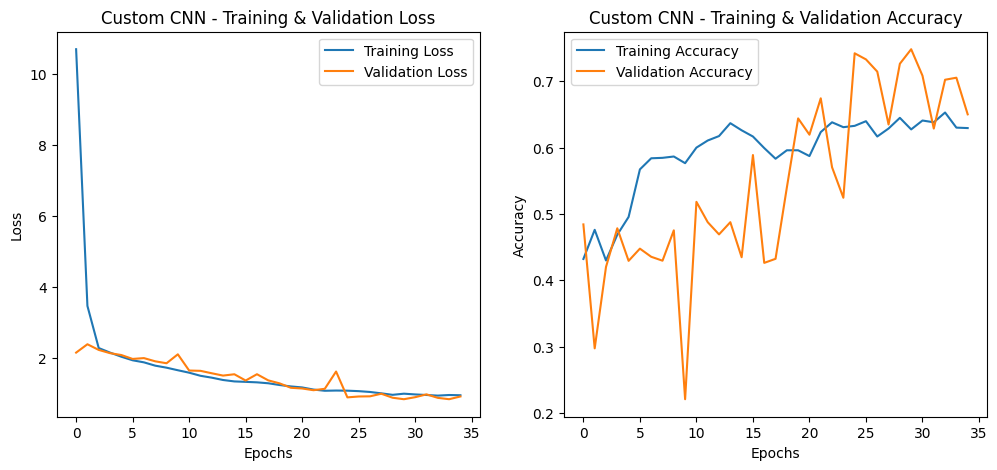

13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 210ms/step


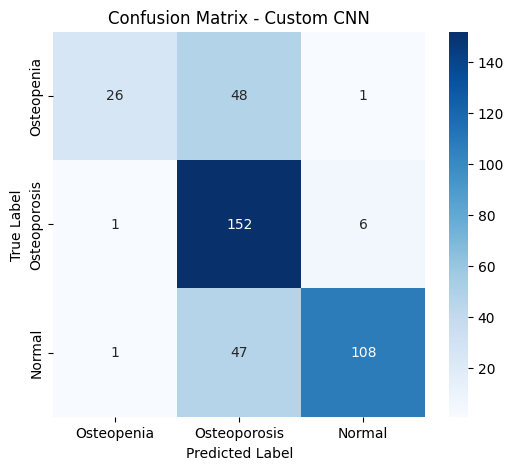

Classification Report for Custom CNN:
              precision    recall  f1-score   support

  Osteopenia       0.93      0.35      0.50        75
Osteoporosis       0.62      0.96      0.75       159
      Normal       0.94      0.69      0.80       156

    accuracy                           0.73       390
   macro avg       0.83      0.66      0.68       390
weighted avg       0.81      0.73      0.72       390



In [4]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.regularizers import l2

# Load CSV file
csv_path = "/kaggle/working/Osteoporosis.csv"
df = pd.read_csv(csv_path)

# Encode labels
label_mapping = {label: idx for idx, label in enumerate(df['label'].unique())}
df['label'] = df['label'].map(label_mapping)

# Load and augment images using Pillow
def load_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path).convert('RGB').resize(target_size)
    img = img_to_array(img) / 255.0  # Normalize
    return img

image_paths = df['image'].values
labels = df['label'].values

# Split dataset (80% training, 20% validation)
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, stratify=labels)

# Data generator with augmentation
data_gen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.2, horizontal_flip=True)

def data_generator(image_paths, labels, batch_size=64):
    while True:
        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]
            images = np.array([load_image(img_path) for img_path in batch_paths])
            yield images, tf.keras.utils.to_categorical(batch_labels, num_classes=3)

train_gen = data_generator(train_paths, train_labels)
val_gen = data_generator(val_paths, val_labels)

# Function to create Custom CNN model
def create_custom_cnn():
    model = Sequential()
    
    # Input Layer
    model.add(Conv2D(64, (3, 3), activation=None, kernel_regularizer=l2(0.001), input_shape=(224, 224, 3)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    
    # First Conv Block
    model.add(Conv2D(128, (3, 3), activation=None, kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D((2, 2)))
    
    # Second Conv Block
    model.add(Conv2D(256, (3, 3), activation=None, kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D((2, 2)))
    
    # Third Conv Block
    model.add(Conv2D(512, (3, 3), activation=None, kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D((2, 2)))
    
    # Fourth Conv Block
    model.add(Conv2D(512, (3, 3), activation=None, kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D((2, 2)))
    
    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))  # 3 classes
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Train and Evaluate the Custom CNN Model
model = create_custom_cnn()
print("Training Custom CNN model...")
history = model.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=len(train_paths) // 64,
    validation_steps=len(val_paths) // 64,
    epochs=100,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)
model.save("/kaggle/working/CustomCNN_2_knee_osteo_model.keras")
print("Custom CNN training complete! Model saved.")

# Plot Training Loss and Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Custom CNN - Training & Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Custom CNN - Training & Validation Accuracy')
plt.show()

# Confusion Matrix
val_images = np.array([load_image(img_path) for img_path in val_paths])
predictions = np.argmax(model.predict(val_images), axis=1)
cm = confusion_matrix(val_labels, predictions)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Custom CNN')
plt.show()

# Classification Report
print("Classification Report for Custom CNN:")
print(classification_report(val_labels, predictions, target_names=label_mapping.keys()))

### Custom CNN 2 Architecture

In [5]:
custom_cnn = tf.keras.models.load_model("/kaggle/working/CustomCNN_2_knee_osteo_model.keras")
print("\nLoaded Custom CNN 2Model Architecture:")
custom_cnn.summary()


Loaded Custom CNN 2Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 222, 222, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 220, 220, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 220, 220, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 220, 220, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 110, 110, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 108, 108, 256)       │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 108, 108, 256)       │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 108, 108, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 52, 52, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 52, 52, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 52, 52, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 24, 24, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 24, 24, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 24, 24, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 512)         │              

 Total params: 68,467,851 (261.18 MB)

 Trainable params: 22,821,635 (87.06 MB)

 Non-trainable params: 2,944 (11.50 KB)

 Optimizer params: 45,643,272 (174.12 MB)

## Custom CNN 3 Model

Training Custom CNN model...
Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 459s 10s/step - accuracy: 0.3821 - loss: 1.4422 - val_accuracy: 0.4089 - val_loss: 1.0608
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 194s 5s/step - accuracy: 0.4116 - loss: 1.0547 - val_accuracy: 0.4018 - val_loss: 1.0529
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 97s 4s/step - accuracy: 0.3928 - loss: 1.0554 - val_accuracy: 0.4080 - val_loss: 1.0500
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.3897 - loss: 1.0519 - val_accuracy: 0.4264 - val_loss: 1.0315
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 98s 4s/step - accuracy: 0.4930 - loss: 0.9698 - val_accuracy: 0.6288 - val_loss: 0.8183
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 96s 4s/step - accuracy: 0.6636 - loss: 0.7845 - val_accuracy: 0.7515 - val_loss: 0.7251
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 96s 4s/step - accuracy: 0.7530 - loss: 0.6312 - val_accuracy: 0.7791 - val_loss: 0.5369
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 97s 4s/step - accuracy: 0.7814 - loss: 0

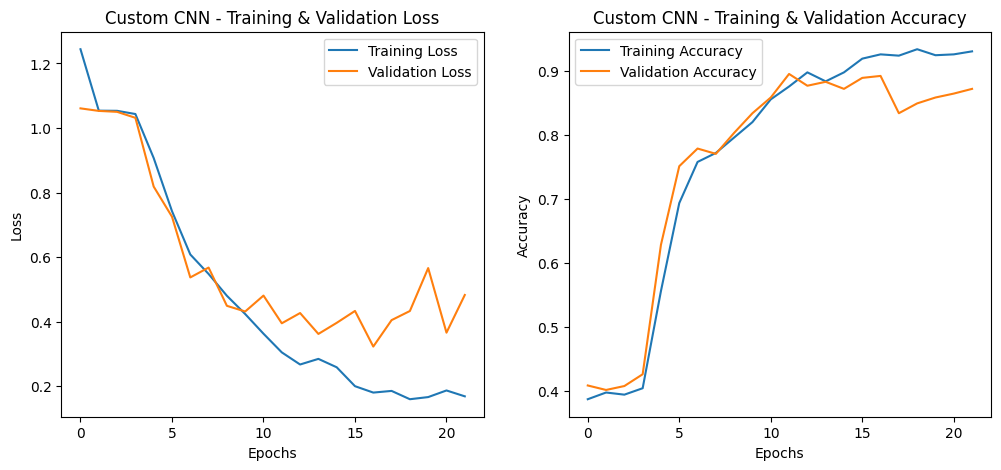

13/13 ━━━━━━━━━━━━━━━━━━━━ 46s 332ms/step


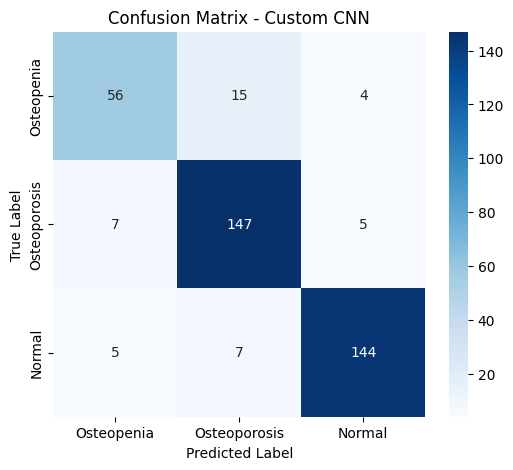

Classification Report for Custom CNN:
              precision    recall  f1-score   support

  Osteopenia       0.82      0.75      0.78        75
Osteoporosis       0.87      0.92      0.90       159
      Normal       0.94      0.92      0.93       156

    accuracy                           0.89       390
   macro avg       0.88      0.86      0.87       390
weighted avg       0.89      0.89      0.89       390



In [ ]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.regularizers import l2

# Load CSV file
csv_path = "/kaggle/working/Osteoporosis.csv"
df = pd.read_csv(csv_path)

# Encode labels
label_mapping = {label: idx for idx, label in enumerate(df['label'].unique())}
df['label'] = df['label'].map(label_mapping)

# Load and augment images using Pillow
def load_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path).convert('RGB').resize(target_size)
    img = img_to_array(img) / 255.0  # Normalize
    return img

image_paths = df['image'].values
labels = df['label'].values

# Split dataset (80% training, 20% validation)
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, stratify=labels)

# Data generator with augmentation
data_gen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.2, horizontal_flip=True)

def data_generator(image_paths, labels, batch_size=64):
    while True:
        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]
            images = np.array([load_image(img_path) for img_path in batch_paths])
            yield images, tf.keras.utils.to_categorical(batch_labels, num_classes=3)

train_gen = data_generator(train_paths, train_labels)
val_gen = data_generator(val_paths, val_labels)

# Function to create Custom CNN model
def create_custom_cnn():
    input_layer = Input(shape=(224, 224, 3))
    
    x = Conv2D(128, (8, 8), activation='relu', padding='same')(input_layer)
    x = Conv2D(256, (5, 5), activation='relu', padding='same')(x)
    x = MaxPooling2D((3, 3))(x)
    
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (1, 1), activation='relu', padding='same')(x)
    
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Flatten()(x)
    x = Dense(3, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=x)
    return model

# Train and Evaluate the Custom CNN Model
model = create_custom_cnn()
print("Training Custom CNN model...")
# Compile the model before training
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=len(train_paths) // 64,
    validation_steps=len(val_paths) // 64,
    epochs=100,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)
model.save("/kaggle/working/CustomCNN_3_knee_osteo_model.keras")
print("Custom CNN training complete! Model saved.")

# Plot Training Loss and Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Custom CNN - Training & Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Custom CNN - Training & Validation Accuracy')
plt.show()

# Confusion Matrix
val_images = np.array([load_image(img_path) for img_path in val_paths])
predictions = np.argmax(model.predict(val_images), axis=1)
cm = confusion_matrix(val_labels, predictions)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Custom CNN')
plt.show()

# Classification Report
print("Classification Report for Custom CNN:")
print(classification_report(val_labels, predictions, target_names=label_mapping.keys()))

### Custom CNN 3 Architecture

In [ ]:
custom_cnn = tf.keras.models.load_model("/kaggle/working/CustomCNN_3_knee_osteo_model.keras")
print("\nLoaded Custom CNN 3 Model Architecture:")
custom_cnn.summary()


Loaded Custom CNN 3 Model Architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 128)       │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 256)       │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 74, 74, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 74, 74, 256)         │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 74, 74, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 37, 37, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 37, 37, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 41472)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │         124,419 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,652,107 (113.11 MB)

 Trainable params: 9,884,035 (37.70 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,768,072 (75.41 MB)

## Custom CNN 4 Model

Training Custom CNN model...
Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 150s 6s/step - accuracy: 0.4678 - loss: 12.8101 - val_accuracy: 0.1823 - val_loss: 1821.5719
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 129s 5s/step - accuracy: 0.5631 - loss: 6.9670 - val_accuracy: 0.3129 - val_loss: 105.0292
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 115s 5s/step - accuracy: 0.5625 - loss: 5.1164 - val_accuracy: 0.3650 - val_loss: 10.2239
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 115s 5s/step - accuracy: 0.5745 - loss: 3.6705 - val_accuracy: 0.4847 - val_loss: 5.1157
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 113s 5s/step - accuracy: 0.5688 - loss: 2.0933 - val_accuracy: 0.4908 - val_loss: 1.6959
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 113s 5s/step - accuracy: 0.6260 - loss: 1.7296 - val_accuracy: 0.6043 - val_loss: 1.2857
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 113s 5s/step - accuracy: 0.6062 - loss: 1.6469 - val_accuracy: 0.5153 - val_loss: 2.0674
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 114s 5s/step - accuracy: 0.64

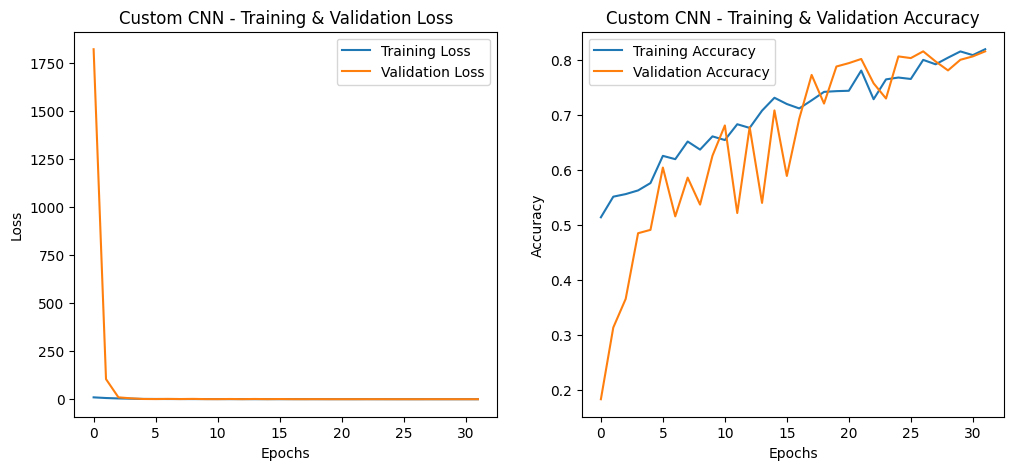

13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 871ms/step


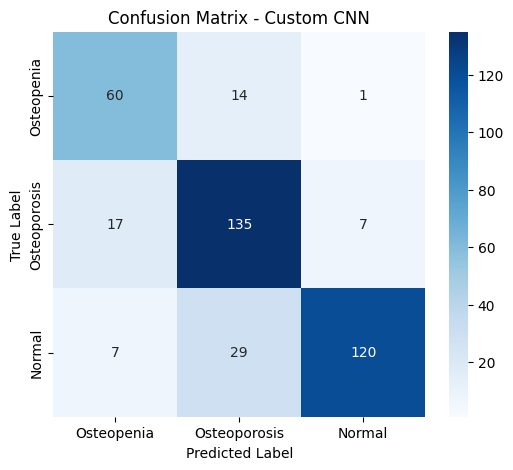

Classification Report for Custom CNN:
              precision    recall  f1-score   support

  Osteopenia       0.71      0.80      0.75        75
Osteoporosis       0.76      0.85      0.80       159
      Normal       0.94      0.77      0.85       156

    accuracy                           0.81       390
   macro avg       0.80      0.81      0.80       390
weighted avg       0.82      0.81      0.81       390



In [ ]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.regularizers import l2

# Load CSV file
csv_path = "/kaggle/working/Osteoporosis.csv"
df = pd.read_csv(csv_path)

# Encode labels
label_mapping = {label: idx for idx, label in enumerate(df['label'].unique())}
df['label'] = df['label'].map(label_mapping)

# Load and augment images using Pillow
def load_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path).convert('RGB').resize(target_size)
    img = img_to_array(img) / 255.0  # Normalize
    return img

image_paths = df['image'].values
labels = df['label'].values

# Split dataset (80% training, 20% validation)
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, stratify=labels)

# Data generator with augmentation
data_gen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.2, horizontal_flip=True)

def data_generator(image_paths, labels, batch_size=64):
    while True:
        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]
            images = np.array([load_image(img_path) for img_path in batch_paths])
            yield images, tf.keras.utils.to_categorical(batch_labels, num_classes=3)

train_gen = data_generator(train_paths, train_labels)
val_gen = data_generator(val_paths, val_labels)

# Function to create Custom CNN model
def create_custom_cnn():
    input_layer = Input(shape=(224, 224, 3))
    
    x = Conv2D(128, (8, 8), padding='same')(input_layer)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(256, (5, 5), padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3, 3))(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(256, (1, 1), padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(512, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(512, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.5)(x)

    x = Dense(256)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.5)(x)

    output_layer = Dense(3, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    return model
    
# Create and compile model
model = create_custom_cnn()

print("Training Custom CNN model...")
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=len(train_paths) // 64,
    validation_steps=len(val_paths) // 64,
    epochs=100,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)
model.save("/kaggle/working/CustomCNN_4_knee_osteo_model.keras")
print("Custom CNN training complete! Model saved.")

# Plot Training Loss and Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Custom CNN - Training & Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Custom CNN - Training & Validation Accuracy')
plt.show()

# Confusion Matrix
val_images = np.array([load_image(img_path) for img_path in val_paths])
predictions = np.argmax(model.predict(val_images), axis=1)
cm = confusion_matrix(val_labels, predictions)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Custom CNN')
plt.show()

# Classification Report
print("Classification Report for Custom CNN:")
print(classification_report(val_labels, predictions, target_names=label_mapping.keys()))

### Custom CNN 4 Architecture

In [ ]:
custom_cnn = tf.keras.models.load_model("/kaggle/working/CustomCNN_4_knee_osteo_model.keras")
print("\nLoaded Custom CNN 4 Model Architecture:")
custom_cnn.summary()


Loaded Custom CNN 4 Model Architecture:


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 224, 224, 128)       │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_20 (LeakyReLU)           │ (None, 224, 224, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 224, 224, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 224, 224, 256)       │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_21 (LeakyReLU)           │ (None, 224, 224, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_33               │ (None, 224, 224, 256)       │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 74, 74, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 74, 74, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_22 (LeakyReLU)           │ (None, 74, 74, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_34               │ (None, 74, 74, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 74, 74, 256)         │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_23 (LeakyReLU)           │ (None, 74, 74, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_35               │ (None, 74, 74, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 74, 74, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_24 (LeakyReLU)           │ (None, 74, 74, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_36               │ (None, 74, 74, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 37, 37, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 37, 37, 512)         │       2,359,8

 Total params: 93,401,227 (356.30 MB)

 Trainable params: 31,131,779 (118.76 MB)

 Non-trainable params: 5,888 (23.00 KB)

 Optimizer params: 62,263,560 (237.52 MB)